In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
csv_path = '..\data\_approach_0.csv'
df = pd.read_csv(csv_path)
df.head()


,time_stamp,date_time,volume_per_hour,speed_kmh,travel_time,free_flow_travel_time,usual_delay_sec,delay_sec
0,1576796430000,20/12/2019 00:01:00,97,33.647537,26,26,-1,0
1,1576796490000,20/12/2019 00:02:00,0,33.647537,26,26,-1,0
2,1576796550001,20/12/2019 00:03:00,0,33.647537,26,26,-1,0
3,1576796610000,20/12/2019 00:04:00,0,33.647537,26,26,-1,0
4,1576796670000,20/12/2019 00:05:00,0,33.647537,26,26,-1,0


In [3]:
df.volume_per_hour = df.volume_per_hour.replace(to_replace=0, method='ffill')
df.speed_kmh = df.speed_kmh.replace(to_replace=0, method='ffill')


In [4]:
TRAIN_SPLIT = 90000
tf.random.set_seed(13)
features_considered = ['volume_per_hour', 'speed_kmh', 'travel_time']
features = df[features_considered]
features.index = df['date_time']
features.head()

,volume_per_hour,speed_kmh,travel_time
date_time,,,
20/12/2019 00:01:00,97,33.647537,26
20/12/2019 00:02:00,97,33.647537,26
20/12/2019 00:03:00,97,33.647537,26
20/12/2019 00:04:00,97,33.647537,26
20/12/2019 00:05:00,97,33.647537,26


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000244675EEA88>,
      dtype=object)

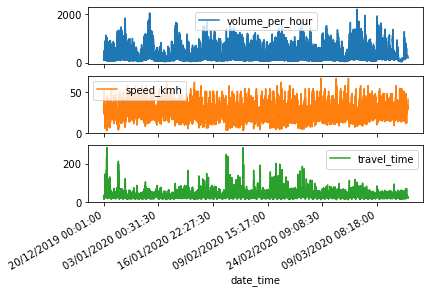

In [5]:
features.plot(subplots=True)

In [6]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [7]:
def get_labeled_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
history_range = 1440
target_range = 5
STEP = 5

x_train_single, y_train_single = get_labeled_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, history_range,
                                                   target_range, STEP,
                                                   single_step=True)
x_val_single, y_val_single = get_labeled_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, history_range,
                                               target_range, STEP,
                                               single_step=True)

per 5 minutes daily history data

In [12]:
print ('single window of history : {}'.format(x_train_single[0].shape))
print('all history: {}'.format(x_train_single.shape))

single window of history : (288, 3)
all history: (88560, 288, 3)


In [13]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [14]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [15]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 84s 420ms/step - loss: 0.4001 - val_loss: 0.4574
Epoch 2/10
200/200 [==============================] - 112s 560ms/step - loss: 0.4055 - val_loss: 0.4351
Epoch 3/10
200/200 [==============================] - 110s 552ms/step - loss: 0.3667 - val_loss: 0.4319
Epoch 4/10
 38/200 [====>.........................] - ETA: 1:25 - loss: 0.3991

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()